<h1 align='center'>Time-Series Analysis on TATA Steel</h1>
<h3 align='center'>Analyze the Data and Predict the Price of the Stock till January</h3>

### Import Initial Packages

In [1]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

#### OBJECTIVES:
1. Data Cleaning 
    - Convert to Date-Time Format
    - Remove unnecessary values (If any)
2. Split the Data into Train and Test 
3. Visualize the Data
4. Feature Scaling
    - Obtain the Independent and Dependent Data
5. Build the Model
    - Stacked-LSTM
6. Future Predictions
7. Model Evaluation
8. Forecast the Future Values  (With the Training Data - TimeStep= 30)
9. Forecast the Future Values  (With the Full Data - TimeStep= 30)
10. Forecast the Future Values  (With the Full Data - TimeStep)
11. Combining the Data

#### END-GOAL:
<strong>Predict the Number of Onboarding Cliets till February 2022 end</strong>

### Loading the Required Data

In [2]:
### Load and View the Data
df = pd.read_csv('TATASTEEL-Full.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,111.728554,112.149643,110.353004,111.868919,57.777229,1024222.0
1,1996-01-02,111.728554,112.149643,109.510826,109.791557,56.704319,1695431.0
2,1996-01-03,109.791557,112.290009,109.510826,109.819626,56.718822,1351411.0
3,1996-01-04,108.079132,108.079132,103.868256,106.338638,54.920979,3478582.0
4,1996-01-05,105.047302,105.552605,103.166443,104.233200,53.833576,3013803.0


### Data Cleaning

In [3]:
### Understanding the Data Type
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

- We can see that the **Date** Column is of type *'object'*. We will convert them to DateTime format.

In [4]:
### Converting the 'Date' Column to datetime format. 

df['Date']=pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,111.728554,112.149643,110.353004,111.868919,57.777229,1024222.0
1,1996-01-02,111.728554,112.149643,109.510826,109.791557,56.704319,1695431.0
2,1996-01-03,109.791557,112.290009,109.510826,109.819626,56.718822,1351411.0
3,1996-01-04,108.079132,108.079132,103.868256,106.338638,54.920979,3478582.0
4,1996-01-05,105.047302,105.552605,103.166443,104.233200,53.833576,3013803.0


In [5]:
## Resetting the Index.
df_Close = df.copy()

df_Close = df_Close[['Date','Close']]
df_Close.head()

,Date,Close
0,1996-01-01,111.868919
1,1996-01-02,109.791557
2,1996-01-03,109.819626
3,1996-01-04,106.338638
4,1996-01-05,104.233200


In [6]:
## Checking for Null Values
df_Close.isnull().any()

Date     False
Close     True
dtype: bool

In [7]:
## Missing values
df_Close[df_Close['Close'].isnull() == True]

,Date,Close
226,1996-11-12,NaN
309,1997-03-07,NaN
335,1997-04-14,NaN
742,1998-11-04,NaN
757,1998-11-25,NaN
779,1998-12-25,NaN
826,1999-03-02,NaN
845,1999-03-29,NaN
866,1999-04-27,NaN
1005,1999-11-08,NaN


> Since these are the missing Dates we will remove them.

In [8]:
df_Close.dropna(inplace= True)
len(df_Close)

6528

### Splitting the Dataset into Train and Test Data

- In case of Time Series Data we will divide the data with respect to Date. This division is done so that we understand how well our Data is Forecasting.

In [9]:
## Train and Test Data
train_size = int(len(df_Close)*0.70)    ## Taking 70% of the Data as Train size.
test_size = len(df_Close)-train_size    ## 30% Test size.

train_data, test_data = df_Close.iloc[0:train_size], df_Close.iloc[train_size:len(df_Close)]      ## Obtaining Train and Test Data.

In [10]:
train_data.tail()

,Date,Close
4580,2014-01-03,393.003876
4581,2014-01-06,389.002380
4582,2014-01-07,376.045166
4583,2014-01-08,373.853851
4584,2014-01-09,372.329468


- From here we can see that the train data is till 9th January 2014.

### Visualize the Time Serie Data.

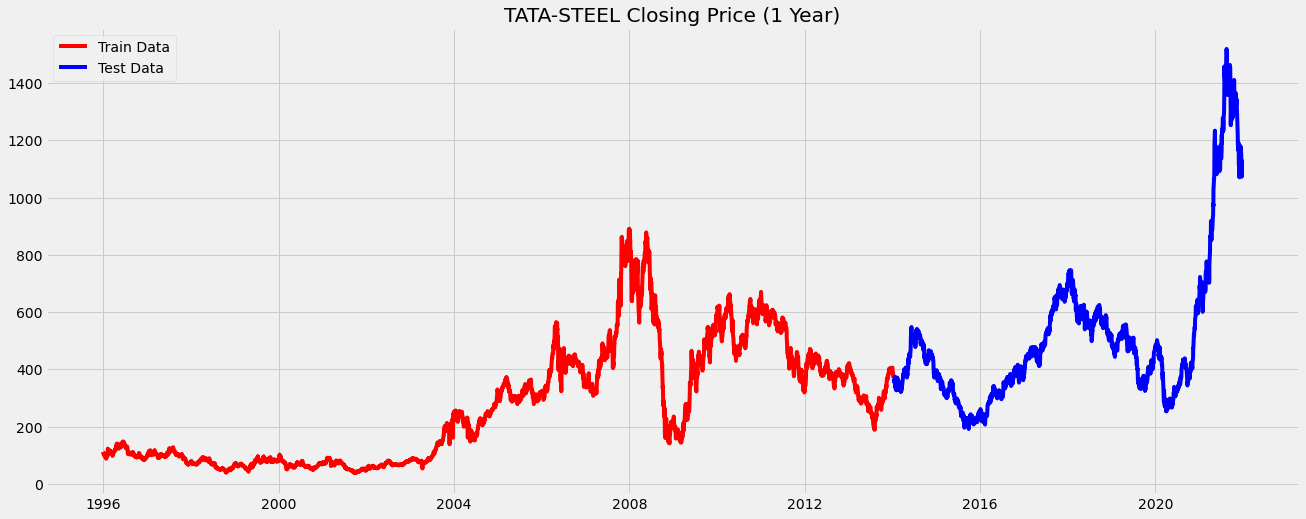

In [11]:
# Visualizing the Onboardings
plt.figure(figsize=(20,8))
plt.plot(train_data.set_index('Date'), label='Train Data', color='red')
plt.plot(test_data.set_index('Date'), label='Test Data', color='blue')
plt.title('TATA-STEEL Closing Price (1 Year)')
plt.legend()
plt.show()

- We can see that for this particular Year (2021) we get a somewhat a decreasing trend towards the end of the plot. 

### Understanding the Different Components

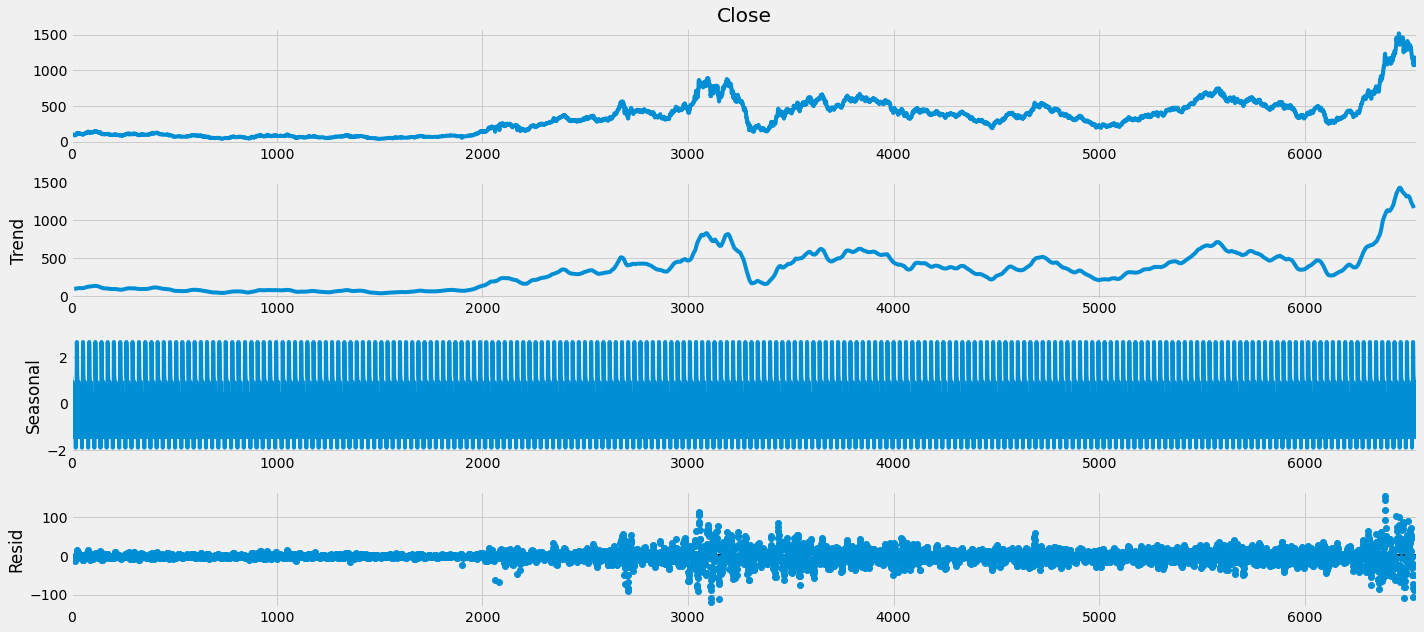

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_Close['Close'], freq = 30)

plt.rcParams.update({'figure.figsize': (20,9)})
decomposition.plot()
plt.show()

**TERMINOLOGIES**

- Observed: The Original Time Series Plot.
- Trend: This is obtained by isolating any of the Seasonality in the Data.
- Seasonal: This is obtained by isolating any of the Trend in the Data.
- Resid: What cant be explained by the Trend and Seasonality Plots (Basically the Noise)

### Data Preprocessing 

#### Feature Scaling

In [13]:
## Resetting the Index and Selecting only the Closing Price Column.
train_data = train_data.reset_index()['Close']
test_data = test_data.reset_index()['Close']
train_data.head()

0    111.868919
1    109.791557
2    109.819626
3    106.338638
4    104.233200
Name: Close, dtype: float64

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1))     ## Setting the range of values to be scaled between 0 and 1.

train_data = scaler.fit_transform(np.array(train_data).reshape(-1,1))
test_data = scaler.fit_transform(np.array(test_data).reshape(-1,1))

print(train_data)

[[0.08683922]
 [0.0844051 ]
 [0.08443799]
 ...
 [0.39638484]
 [0.39381719]
 [0.39203101]]


#### Obtaining Independent and Dependent Features

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator

## Converting to Independent and Dependent Features (based on TimeSteps)
def get_data(dataset, timestep= 1):
    Xdata, ydata = [], []
    for i in range(len(dataset) - timestep - 1):
        generator = TimeseriesGenerator(dataset, dataset, length=timestep, batch_size= 1)
        X,y = generator[i]
        Xdata.append(X.flatten())
        ydata.append(y.flatten()[0])  ## Here we will obtain our Output.
    return np.array(Xdata), np.array(ydata)

**Timesteps:** How many previous days data should be considered for the prediction of the next day.

In [16]:
## Obtaining X_train, X_test, y_train and y_test
timestep= 60
X_train, y_train = get_data(train_data, timestep= timestep)
X_test, y_test = get_data(test_data, timestep= timestep)

In [17]:
## Viewing the training Dataset
print(X_train)
print()
print()
print(y_train)

[[0.08683922 0.0844051  0.08443799 ... 0.07065555 0.07779347 0.07585275]
 [0.0844051  0.08443799 0.08035918 ... 0.07779347 0.07585275 0.07943815]
 [0.08443799 0.08035918 0.07789215 ... 0.07585275 0.07943815 0.0827933 ]
 ...
 [0.28709332 0.29429382 0.30026634 ... 0.43121522 0.42373562 0.41625602]
 [0.29429382 0.30026634 0.29948491 ... 0.42373562 0.41625602 0.41156731]
 [0.30026634 0.29948491 0.29245182 ... 0.41625602 0.41156731 0.39638484]]


[0.07943815 0.0827933  0.08631293 ... 0.41156731 0.39638484 0.39381719]


In [18]:
print(X_train.shape), print(y_train.shape)

(4508, 60)
(4508,)


(None, None)

### Creating a Stacked-LSTM Model

In [19]:
## Reshape Input data to a 3-Dimensional data (i.e. (Observations, Timesteps) --> (Observations, Timesteps, Features)) 
## This process is very important before proceeding with the LSTM model.

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [21]:
X_train.shape[0], X_train.shape[1], 1

(4508, 60, 1)

In [22]:
## Create the LSTM Model
model = Sequential()

## Stacked LSTM model with 20 hidden layers.
model.add(LSTM(20, activation='relu', return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(20, activation='relu'))

## Output Layer
model.add(Dense(1))

## Model Summary
model.summary()

2022-01-11 21:34:29.107931: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 20)            1760      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


**REFER:** https://www.heatonresearch.com/2017/06/01/hidden-layers.html -- Why did I choose 20 hidden Layers for each LSTM

In [23]:
## Compile the model
model.compile(loss= 'mean_squared_error', optimizer= 'adam')

## Training Procedure
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs= 100, batch_size= 64, verbose= 1, shuffle= False)

Epoch 1/100
71/71 [==============================] - 7s 65ms/step - loss: 0.0238 - val_loss: 0.0188
Epoch 2/100
71/71 [==============================] - 4s 56ms/step - loss: 0.0205 - val_loss: 0.0182
Epoch 3/100
71/71 [==============================] - 4s 62ms/step - loss: 0.0178 - val_loss: 0.0057
Epoch 4/100
71/71 [==============================] - 4s 55ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 5/100
71/71 [==============================] - 4s 53ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 6/100
71/71 [==============================] - 4s 54ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 7/100
71/71 [==============================] - 4s 52ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 8/100
71/71 [==============================] - 4s 52ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 9/100
71/71 [==============================] - 4s 63ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 10/100
71/71 [==============================] - 4s 54ms/step - loss: 0.0029 - val_loss: 0.0023

#### Plotting the Loss-Per-Epoch Curve

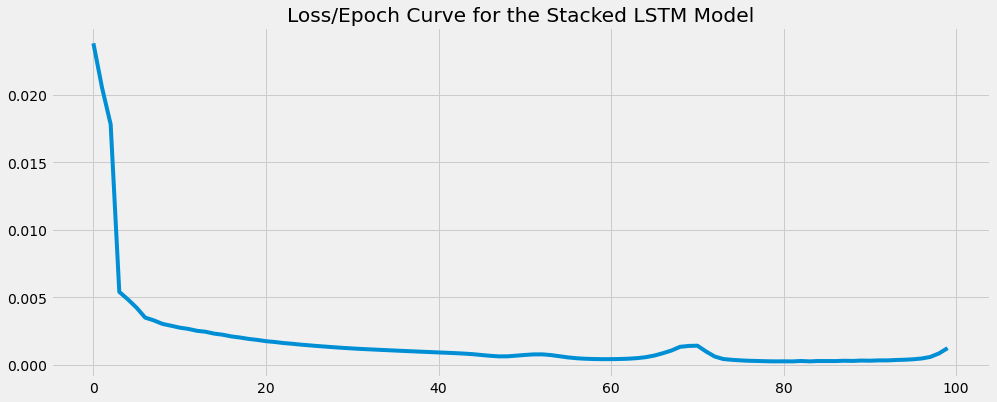

In [24]:
LPE = model.history.history['loss']

plt.figure(figsize= (15,6))
plt.plot(range(len(LPE)),LPE)
plt.title('Loss/Epoch Curve for the Stacked LSTM Model')
plt.show()

### Prediction on Train and Test Data
- This is because we need to find the performance Matrix.

In [25]:
## Predictions
ytrain_pred = model.predict(X_train)
ytest_pred = model.predict(X_test)

### Model Evaluation

In [26]:
# Accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


def forecast_accuracy(forecast, actual):
    MSE = mean_squared_error(actual, forecast)                    ## np.mean((forecast - actual)**2)             
    MAE = mean_absolute_error(actual, forecast)                        ## np.mean(np.abs(forecast - actual))    
    RMSE = sqrt(MSE)                                                       ## np.mean((forecast - actual)**2)**.5  

    print(f'Mean Squared Error:{MSE} || Mean Absolute Error:{MAE} || Root Mean Squared Error:{RMSE}')

In [27]:
## Calculating the Metrics (Train)
forecast_accuracy(y_train, ytrain_pred)

Mean Squared Error:0.0025829752563917285 || Mean Absolute Error:0.04425734901853025 || Root Mean Squared Error:0.050822979609540096


In [28]:
## Calculating the Metrics (Test)
forecast_accuracy(y_test, ytest_pred)

Mean Squared Error:0.0018464163843628161 || Mean Absolute Error:0.035361438830512265 || Root Mean Squared Error:0.04296994745590011


### Visualization

In [29]:
## Resetting the Index and Selecting only the Onboarding Column. (For Original Data)
df_CloseNew = df_Close.reset_index()['Close']
df_CloseNew = scaler.fit_transform(np.array(df_CloseNew).reshape(-1,1))

In [30]:
## Transform back Scaled Data to Original Data
ytrain_pred = scaler.inverse_transform(ytrain_pred)
ytest_pred = scaler.inverse_transform(ytest_pred)

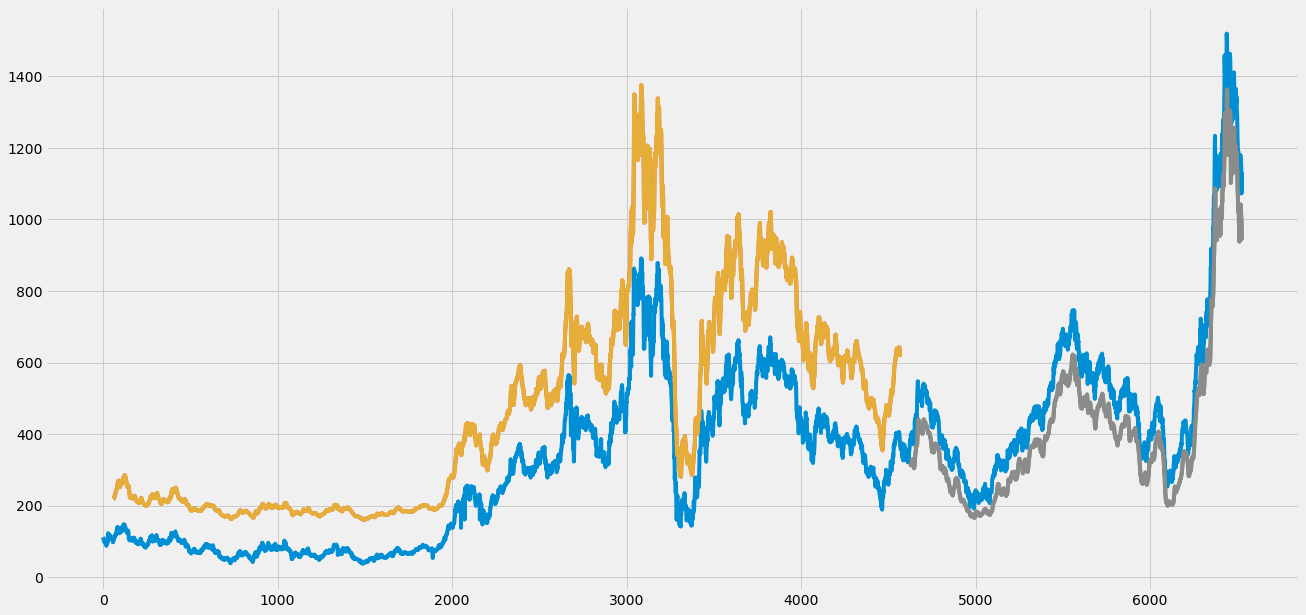

In [31]:
## Shift Train Predictions for Plotting
timestep= 60
TrainPredictPlot = np.empty_like(df_Close)
TrainPredictPlot[:, :] = np.nan
TrainPredictPlot[timestep: len(ytrain_pred) + timestep, :] = ytrain_pred         

## Shift Test Predictions for Plotting
timestep= 60
TestPredictPlot = np.empty_like(df_Close)
TestPredictPlot[:, :] = np.nan
TestPredictPlot[len(ytrain_pred) + (timestep*2) + 1:len(df_Close) - 1, :] = ytest_pred

## Baseline and Predictions Plot
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(df_CloseNew))
plt.plot(TrainPredictPlot)
plt.plot(TestPredictPlot)
plt.show()

In the above plot:

- Blue represents the Original Data.
- Yellow Represents the Predictions made on the Train Data.
- Gray Represents the Predictions made on the Test Data.

### Future Predictions

- We will now be Predicting till February 2022 and Plot the Output

In [32]:
len(test_data), X_test.shape

(1959, (1898, 60, 1))

In [33]:
## Selecting the Previous 60 Days to Predict the Next Day Onboarding Number
Input_data = test_data[len(test_data)-60:, :].reshape(1, -1)
Input_data.shape

(1, 60)

In [34]:
Input_data

array([[0.82037914, 0.83137718, 0.82636782, 0.83310968, 0.85292111,
        0.84742209, 0.81958825, 0.82659375, 0.83559556, 0.84467258,
        0.85664983, 0.87563267, 0.89126333, 0.91838159, 0.88512404,
        0.86734654, 0.84580251, 0.83190444, 0.82968229, 0.86761017,
        0.85442768, 0.83442793, 0.84674412, 0.88361747, 0.84501162,
        0.85435237, 0.85423936, 0.86730883, 0.86180982, 0.83363703,
        0.83442793, 0.82512488, 0.79363753, 0.78109541, 0.77450416,
        0.74930673, 0.73307349, 0.75341218, 0.74320514, 0.73955172,
        0.69333771, 0.69518322, 0.66237762, 0.67092748, 0.69341302,
        0.6976314 , 0.69070121, 0.72083261, 0.73906207, 0.7419622 ,
        0.74433506, 0.73326181, 0.73469298, 0.72478736, 0.72414699,
        0.7082527 , 0.66369587, 0.687914  , 0.70580452, 0.70490061]])

In [35]:
## Converting Inputs to a List
List_Input = list(Input_data)     ## Converts 2D array to a 1D array.
List_Input = List_Input[0].tolist()   ## Converts 1D array to a list.

In [36]:
df_Close.tail(1)          ### Viewing the Last Date in our Data.

,Date,Close
6545,2021-12-23,1127.650024


In [37]:
### Checking the Number of days between December 24th 2021 to February 28th 2022
len(pd.date_range(start= datetime.date(2021, 12, 24), end= datetime.date(2022, 2, 28)))

67

In [38]:
## Prediction for next 67 days
output = []
n_steps = 60
i = 0

while (i<67):

  if (len(List_Input) > 60):
    Input_data = np.array(List_Input[1:])
    print(f"{i} day input {Input_data}")
    Input_data = Input_data.reshape(1, -1)
    Input_data = Input_data.reshape((1, n_steps, 1))
    ypred = model.predict(Input_data, verbose= 0)
    print(f"{i} day output {ypred}")
    
    ## Adding Predicted value inside the Previous Data so as to have the extra elements for Future Prediction.
    List_Input.extend(ypred[0].tolist())
    List_Input = List_Input[1:]

    ## Adding Predicted value inside the Output List
    output.extend(ypred.tolist())                 
    i = i + 1

  else:
    Input_data = Input_data.reshape((1, n_steps, 1))      ## Reshaping as LSTM requires 3D Data.
    ypred = model.predict(Input_data, verbose= 0)
    print(ypred[0])

    List_Input.extend(ypred[0].tolist())
    print(len(List_Input))

    output.extend(ypred.tolist())               
    i = i + 1

print(output)

[0.6349995]
61
1 day input [0.83137718 0.82636782 0.83310968 0.85292111 0.84742209 0.81958825
 0.82659375 0.83559556 0.84467258 0.85664983 0.87563267 0.89126333
 0.91838159 0.88512404 0.86734654 0.84580251 0.83190444 0.82968229
 0.86761017 0.85442768 0.83442793 0.84674412 0.88361747 0.84501162
 0.85435237 0.85423936 0.86730883 0.86180982 0.83363703 0.83442793
 0.82512488 0.79363753 0.78109541 0.77450416 0.74930673 0.73307349
 0.75341218 0.74320514 0.73955172 0.69333771 0.69518322 0.66237762
 0.67092748 0.69341302 0.6976314  0.69070121 0.72083261 0.73906207
 0.7419622  0.74433506 0.73326181 0.73469298 0.72478736 0.72414699
 0.7082527  0.66369587 0.687914   0.70580452 0.70490061 0.63499951]
1 day output [[0.5983639]]
2 day input [0.82636782 0.83310968 0.85292111 0.84742209 0.81958825 0.82659375
 0.83559556 0.84467258 0.85664983 0.87563267 0.89126333 0.91838159
 0.88512404 0.86734654 0.84580251 0.83190444 0.82968229 0.86761017
 0.85442768 0.83442793 0.84674412 0.88361747 0.84501162 0.8543

In [39]:
## Creating and Index for the Previous 60 and the Future 67 Days
New_Day = np.arange(1,61)
Pred_Day = np.arange(61, 128)

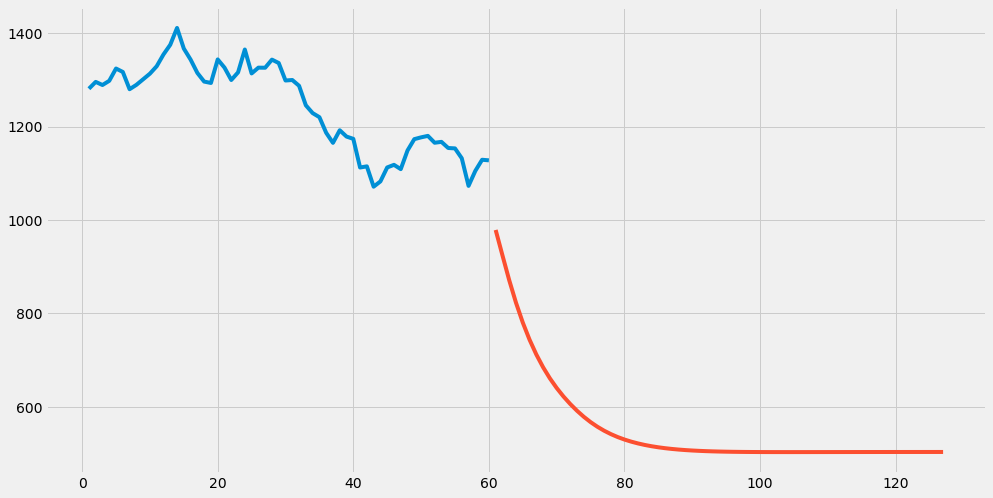

In [40]:
plot_index = len(df_CloseNew) - timestep
plt.figure(figsize= (15,8))
plt.plot(New_Day, scaler.inverse_transform(df_CloseNew[plot_index:]))    ## 275-30 = 245
plt.plot(Pred_Day, scaler.inverse_transform(output))

#### Combining the Dataframes (Forecast Based on just Training Data)

In [41]:
df_next3 = pd.DataFrame(scaler.inverse_transform(output))
df_next3['Date'] = pd.date_range(start= datetime.date(2021, 12, 24), periods= 67)
df_next3.rename(columns = {0:'Close'}, inplace = True)
df_next3            ## Getting values for all the Days.

,Close,Date
0,978.599788,2021-12-24
1,924.318870,2021-12-25
2,871.029087,2021-12-26
3,822.768275,2021-12-27
4,780.385472,2021-12-28
...,...,...
62,503.317740,2022-02-24
63,503.324098,2022-02-25
64,503.329750,2022-02-26
65,503.334651,2022-02-27


In [42]:
## Selecting only the WeekDays
required = pd.DataFrame(pd.date_range(start= datetime.date(2021,12,24), end= datetime.date(2022,2,28), freq= 'B'), columns= ['Date'])

common = df_next3.merge(required, on=["Date"])
result = df_next3[df_next3.Date.isin(common.Date)]

## Setting the Index with the correct values
result.set_index('Date', inplace= True)
result.reset_index(inplace= True)
result

,Date,Close
0,2021-12-24,978.599788
1,2021-12-27,822.768275
2,2021-12-28,780.385472
3,2021-12-29,743.657337
4,2021-12-30,711.957731
5,2021-12-31,684.586688
6,2022-01-03,622.144522
7,2022-01-04,606.028588
8,2022-01-05,591.583886
9,2022-01-06,578.656044


In [43]:
## Full Dataset
df_final = pd.concat([df_Close, result], axis=0)
df_final.set_index('Date', inplace= True)

In [44]:
pd.set_option('display.max_rows', None)
df_final.tail(51)

,Close
Date,
2021-12-20,1072.949951
2021-12-21,1105.099976
2021-12-22,1128.849976
2021-12-23,1127.650024
2021-12-24,978.599788
2021-12-27,822.768275
2021-12-28,780.385472
2021-12-29,743.657337
2021-12-30,711.957731


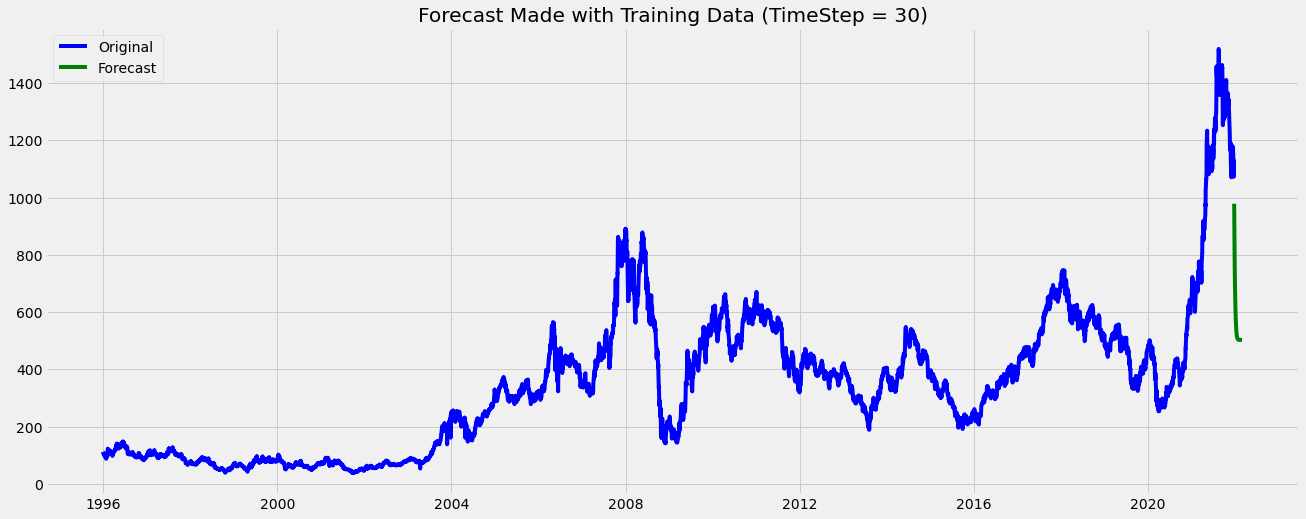

In [45]:
plt.figure(figsize=(20,8))
plt.plot(df_Close.set_index('Date'), color= 'blue', label= 'Original')
plt.plot(result.set_index('Date'), color= 'green', label= 'Forecast')
plt.legend(loc='best')
plt.title('Forecast Made with Training Data (TimeStep = 30)')
plt.show()

In [46]:
len(df_final)

6575

- Looking at the pattern of our Forecast we can concur that ther trend is decreasing overtime.

---
---

<h3 align='center'>Forecast using Previous 60 Days Input (Full Dataset)</h3>

In [59]:
df_new = df.copy()
df_new.dropna(inplace= True)
df_new.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,111.728554,112.149643,110.353004,111.868919,57.777229,1024222.0
1,1996-01-02,111.728554,112.149643,109.510826,109.791557,56.704319,1695431.0
2,1996-01-03,109.791557,112.290009,109.510826,109.819626,56.718822,1351411.0
3,1996-01-04,108.079132,108.079132,103.868256,106.338638,54.920979,3478582.0
4,1996-01-05,105.047302,105.552605,103.166443,104.233200,53.833576,3013803.0


In [60]:
len(df_new)

6528

### Feature Scaling the Full Data

In [61]:
## Resetting the Index and Selecting only the Onboarding Column.
train = df_new.reset_index()['Close']

## Feature Scaling
scaler = MinMaxScaler(feature_range= (0,1))     ## Setting the range of values to be scaled between 0 and 1.as_integer_ratio

train = scaler.fit_transform(np.array(train).reshape(-1,1))
print(train)

[[0.05001976]
 [0.04861769]
 [0.04863664]
 ...
 [0.72037786]
 [0.73640737]
 [0.73559749]]


In [62]:
## Obtaining X_train, and y_train based on previous 60 Days
timestep= 60
X_trainFinal, y_trainFinal = get_data(train, timestep= timestep)

In [63]:
## Viewing the training Dataset
print(X_trainFinal)
print()
print()
print(y_trainFinal)

[[0.05001976 0.04861769 0.04863664 ... 0.0406979  0.04480937 0.0436915 ]
 [0.04861769 0.04863664 0.04628723 ... 0.04480937 0.0436915  0.04575671]
 [0.04863664 0.04628723 0.04486621 ... 0.0436915  0.04575671 0.04768929]
 ...
 [0.85583569 0.86454217 0.83309061 ... 0.75341557 0.75284182 0.73860088]
 [0.86454217 0.83309061 0.83201074 ... 0.75284182 0.73860088 0.69867895]
 [0.83309061 0.83201074 0.83906369 ... 0.73860088 0.69867895 0.72037786]]


[0.04575671 0.04768929 0.04971661 ... 0.69867895 0.72037786 0.73640737]


In [64]:
print(X_trainFinal.shape), print(y_trainFinal.shape)

(6467, 60)
(6467,)


(None, None)

### Stacked-LSTM (Full Model)

In [65]:
## Reshape Input data to a 3-Dimensional data (i.e. (Observations, Timesteps) --> (Observations, Timesteps, Features)) 
## This process is very important before proceeding with the LSTM model.

X_trainFinal = X_trainFinal.reshape(X_trainFinal.shape[0], X_trainFinal.shape[1], 1)

In [66]:
## Create the LSTM Model
model = Sequential()

## Stacked LSTM model with 20 hidden layers.
model.add(LSTM(20, activation='relu', return_sequences= True, input_shape= (X_trainFinal.shape[1], 1)))
model.add(LSTM(20, activation='relu'))

## Output Layer
model.add(Dense(1))

## Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 20)            1760      
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [67]:
## Compile the model
model.compile(loss= 'mean_squared_error', optimizer= 'adam')

## Training Procedure
model.fit(X_trainFinal, y_trainFinal, epochs= 100, batch_size= 64, verbose= 1, shuffle= False)

Epoch 1/100
102/102 [==============================] - 9s 61ms/step - loss: 0.0083
Epoch 2/100
102/102 [==============================] - 6s 63ms/step - loss: 0.0151
Epoch 3/100
102/102 [==============================] - 7s 64ms/step - loss: 1.2698: 0s - lo
Epoch 4/100
102/102 [==============================] - 7s 64ms/step - loss: 0.0209
Epoch 5/100
102/102 [==============================] - 7s 65ms/step - loss: 0.0086
Epoch 6/100
102/102 [==============================] - 7s 64ms/step - loss: 0.0061
Epoch 7/100
102/102 [==============================] - 7s 66ms/step - loss: 0.0029
Epoch 8/100
102/102 [==============================] - 7s 68ms/step - loss: 0.0013
Epoch 9/100
102/102 [==============================] - 7s 71ms/step - loss: 6.1326e-04
Epoch 10/100
102/102 [==============================] - 7s 68ms/step - loss: 6.2582e-04
Epoch 11/100
102/102 [==============================] - 7s 66ms/step - loss: 5.5859e-04
Epoch 12/100
102/102 [==============================] - 7s 67ms/

### Future Forecasting (Full Model)

In [68]:
## Selecting the Previous 60 Days to Predict the Next Day Onboarding Number
Input_data = train[len(train)-60:, :].reshape(1, -1)
Input_data.shape

(1, 60)

In [69]:
## Converting Inputs to a List
List_Input = list(Input_data)     ## Converts 2D array to a 1D array.
List_Input = List_Input[0].tolist()   ## Converts 1D array to a list.

In [70]:
## Prediction for next 67 days
output = []
n_steps = 60
i = 0

while (i<67):

  if (len(List_Input) > 60):
    Input_data = np.array(List_Input[1:])
    print(f"{i} day input {Input_data}")
    Input_data = Input_data.reshape(1, -1)
    Input_data = Input_data.reshape((1, n_steps, 1))
    ypred = model.predict(Input_data, verbose= 0)
    print(f"{i} day output {ypred}")
    
    ## Adding Predicted value inside the Previous Data so as to have the extra elements for Future Prediction.
    List_Input.extend(ypred[0].tolist())
    List_Input = List_Input[1:]

    ## Adding Predicted value inside the Output List
    output.extend(ypred.tolist())                 
    i = i + 1

  else:
    Input_data = Input_data.reshape((1, n_steps, 1))      ## Reshaping as LSTM requires 3D Data.
    ypred = model.predict(Input_data, verbose= 0)
    print(ypred[0])

    List_Input.extend(ypred[0].tolist())
    print(len(List_Input))

    output.extend(ypred.tolist())               
    i = i + 1

print(output)

[0.7271278]
61
1 day input [0.84891769 0.84442941 0.85046997 0.86822057 0.86329358 0.83835507
 0.84463184 0.85269726 0.86083008 0.87156143 0.88856963 0.90257436
 0.92687172 0.89707369 0.88114544 0.86184247 0.8493901  0.8473991
 0.88138164 0.86957043 0.85165109 0.86268613 0.89572383 0.86113384
 0.86950295 0.8694017  0.88111166 0.87618466 0.85094247 0.85165109
 0.84331576 0.8151038  0.80386634 0.79796073 0.77538438 0.76083976
 0.77906278 0.76991749 0.76664411 0.72523738 0.72689092 0.69749783
 0.70515831 0.72530486 0.72908443 0.72287514 0.7498722  0.7662054
 0.76880385 0.77092988 0.76100849 0.76229079 0.75341557 0.75284182
 0.73860088 0.69867895 0.72037786 0.73640737 0.73559749 0.72712779]
1 day output [[0.7257214]]
2 day input [0.84442941 0.85046997 0.86822057 0.86329358 0.83835507 0.84463184
 0.85269726 0.86083008 0.87156143 0.88856963 0.90257436 0.92687172
 0.89707369 0.88114544 0.86184247 0.8493901  0.8473991  0.88138164
 0.86957043 0.85165109 0.86268613 0.89572383 0.86113384 0.869502

#### Combining the Dataframes (Forecat Based on Full Data)

In [71]:
Forecasted = pd.DataFrame(scaler.inverse_transform(output))
Forecasted['Date'] = pd.date_range(start= datetime.date(2021, 12, 24), periods= 67)
Forecasted.rename(columns = {0:'Close'}, inplace = True)
Forecasted            ## Getting values for all the Days.

,Close,Date
0,1115.100959,2021-12-24
1,1113.017219,2021-12-25
2,1110.891177,2021-12-26
3,1108.819094,2021-12-27
4,1106.816249,2021-12-28
5,1104.896418,2021-12-29
6,1103.053948,2021-12-30
7,1101.284690,2021-12-31
8,1099.578929,2022-01-01
9,1097.934633,2022-01-02


In [72]:
## Selecting only the WeekDays
required1 = pd.DataFrame(pd.date_range(start= datetime.date(2021,12,24), end= datetime.date(2022,2,28), freq= 'B'), columns= ['Date'])

common1 = Forecasted.merge(required1, on=["Date"])
result1 = Forecasted[Forecasted.Date.isin(common1.Date)]

## Setting the Index with the correct values
result1.set_index('Date', inplace= True)
result1.reset_index(inplace= True)
result1

,Date,Close
0,2021-12-24,1115.100959
1,2021-12-27,1108.819094
2,2021-12-28,1106.816249
3,2021-12-29,1104.896418
4,2021-12-30,1103.053948
5,2021-12-31,1101.284690
6,2022-01-03,1096.347564
7,2022-01-04,1094.814455
8,2022-01-05,1093.328857
9,2022-01-06,1091.886709


In [73]:
FinalModel = pd.concat([df_new[['Date', 'Close']], result1], axis=0)
FinalModel.set_index('Date', inplace= True)
FinalModel.tail(51)

,Close
Date,
2021-12-20,1072.949951
2021-12-21,1105.099976
2021-12-22,1128.849976
2021-12-23,1127.650024
2021-12-24,1115.100959
2021-12-27,1108.819094
2021-12-28,1106.816249
2021-12-29,1104.896418
2021-12-30,1103.053948


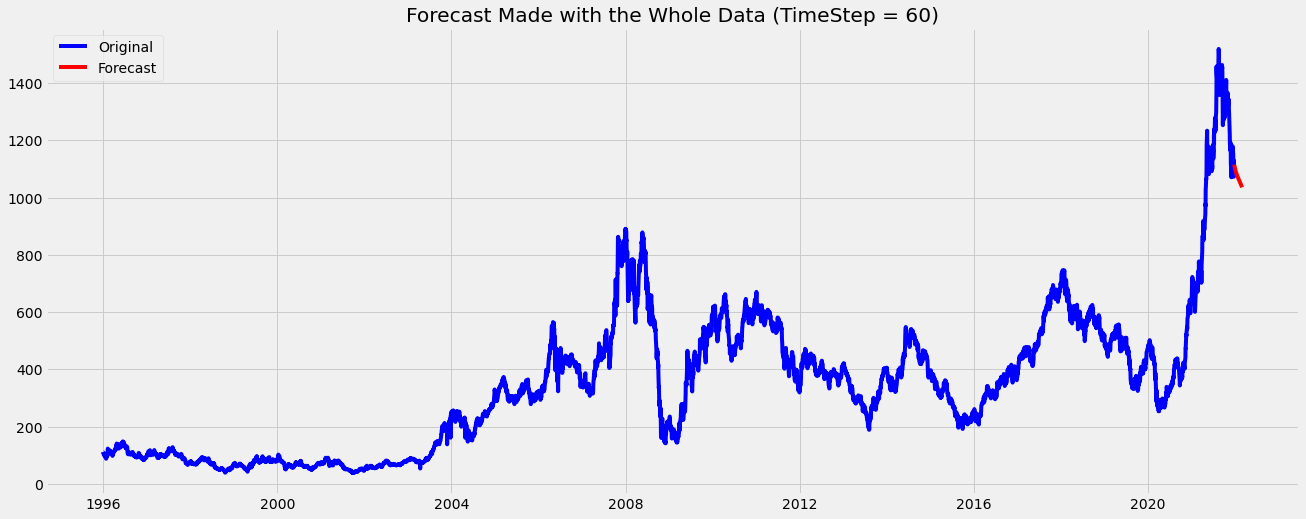

In [74]:
plt.figure(figsize=(20,8))
plt.plot(df_new[['Date', 'Close']].set_index('Date'), color= 'blue', label= 'Original')
plt.plot(result1.set_index('Date'), color= 'red', label= 'Forecast')
plt.legend(loc='best')
plt.title('Forecast Made with the Whole Data (TimeStep = 60)')
plt.show()

---
---

<h3 align='center'>Forecast using Previous Whole Days as Input (Full Dataset)</h3>

In [79]:
df_Open = df.copy()
df_Open.dropna(inplace= True)
df_Open.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1996-01-01,111.728554,112.149643,110.353004,111.868919,57.777229,1024222.0
1,1996-01-02,111.728554,112.149643,109.510826,109.791557,56.704319,1695431.0
2,1996-01-03,109.791557,112.290009,109.510826,109.819626,56.718822,1351411.0
3,1996-01-04,108.079132,108.079132,103.868256,106.338638,54.920979,3478582.0
4,1996-01-05,105.047302,105.552605,103.166443,104.233200,53.833576,3013803.0


### Feature Scaling (Full Data)

In [80]:
## Resetting the Index and Selecting only the Close Price Column.
df_Open = df_Open[['Date', 'Close']]
df_Open = df_Open.reset_index()['Close']
df_Open.head()

0    111.868919
1    109.791557
2    109.819626
3    106.338638
4    104.233200
Name: Close, dtype: float64

In [81]:
df_Open = scaler.fit_transform(np.array(df_Open).reshape(-1,1))
print(df_Open)

[[0.05001976]
 [0.04861769]
 [0.04863664]
 ...
 [0.72037786]
 [0.73640737]
 [0.73559749]]


#### Obtaining Independent and Dependent Features

In [82]:
len(df_Open)

6528

In [87]:
## Obtaining X_train and y_train based on all the previous Days
timestep= len(df_Open)-2
X_value, y_value = get_data(df_Open, timestep= timestep)

In [88]:
## Viewing the training Dataset
print(X_value)
print()
print()
print(y_value)

[[0.05001976 0.04861769 0.04863664 ... 0.73860088 0.69867895 0.72037786]]


[0.73640737]


In [89]:
print(X_value.shape), print(y_value.shape)

(1, 6526)
(1,)


(None, None)

### Stacked-LSTM (Full Model)

In [90]:
## Reshape Input data to a 3-Dimensional data (i.e. (Observations, Timesteps) --> (Observations, Timesteps, Features)) 
## This process is very important before proceeding with the LSTM model.

X_value = X_value.reshape(X_value.shape[0], X_value.shape[1], 1)

In [91]:
## Create the LSTM Model
model = Sequential()

## Stacked LSTM model with 20 hidden layers.
model.add(LSTM(20, activation='relu', return_sequences= True, input_shape= (X_value.shape[1], 1)))
model.add(LSTM(20, activation='relu'))

## Output Layer
model.add(Dense(1))

## Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 6526, 20)          1760      
                                                                 
 lstm_7 (LSTM)               (None, 20)                3280      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [92]:
## Compile the model
model.compile(loss= 'mean_squared_error', optimizer= 'adam')

## Training Procedure
model.fit(X_value, y_value, epochs= 100, batch_size= 64, verbose= 1, shuffle= False)

Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 0.4861
Epoch 2/100
1/1 [==============================] - 9s 9s/step - loss: 0.4693
Epoch 3/100
1/1 [==============================] - 8s 8s/step - loss: 0.4523
Epoch 4/100
1/1 [==============================] - 9s 9s/step - loss: 0.4354
Epoch 5/100
1/1 [==============================] - 9s 9s/step - loss: 0.4187
Epoch 6/100
1/1 [==============================] - 8s 8s/step - loss: 0.4022
Epoch 7/100
1/1 [==============================] - 8s 8s/step - loss: 0.3861
Epoch 8/100
1/1 [==============================] - 9s 9s/step - loss: 0.3702
Epoch 9/100
1/1 [==============================] - 8s 8s/step - loss: 0.3543
Epoch 10/100
1/1 [==============================] - 8s 8s/step - loss: 0.3382
Epoch 11/100
1/1 [==============================] - 9s 9s/step - loss: 0.3220
Epoch 12/100
1/1 [==============================] - 8s 8s/step - loss: 0.3058
Epoch 13/100
1/1 [==============================] - 8s 8s/step - loss: 

### Future Forecasting (Full Model)

In [95]:
## Selecting the Previous 237 Days to Predict the Next Day Onboarding Number
Input_data = df_Open[len(df_Open)-6526:, :].reshape(1, -1)
Input_data.shape

(1, 6526)

In [96]:
## Converting Inputs to a List
List_Input = list(Input_data)     ## Converts 2D array to a 1D array.
List_Input = List_Input[0].tolist()   ## Converts 1D array to a list.

In [97]:
## Prediction for next 67 days
output = []
n_steps = 6526
i = 0

while (i<67):

  if (len(List_Input) > 6526):
    Input_data = np.array(List_Input[1:])
    print(f"{i} day input {Input_data}")
    Input_data = Input_data.reshape(1, -1)
    Input_data = Input_data.reshape((1, n_steps, 1))
    ypred = model.predict(Input_data, verbose= 0)
    print(f"{i} day output {ypred}")
    
    ## Adding Predicted value inside the Previous Data so as to have the extra elements for Future Prediction.
    List_Input.extend(ypred[0].tolist())
    List_Input = List_Input[1:]

    ## Adding Predicted value inside the Output List
    output.extend(ypred.tolist())                 
    i = i + 1

  else:
    Input_data = Input_data.reshape((1, n_steps, 1))      ## Reshaping as LSTM requires 3D Data.
    ypred = model.predict(Input_data, verbose= 0)
    print(ypred[0])

    List_Input.extend(ypred[0].tolist())
    print(len(List_Input))

    output.extend(ypred.tolist())               
    i = i + 1

print(output)

[0.7306414]
6527
1 day input [0.04628723 0.04486621 0.04223259 ... 0.73640737 0.73559749 0.73064142]
1 day output [[0.72826624]]
2 day input [0.04486621 0.04223259 0.0419105  ... 0.73559749 0.73064142 0.72826624]
2 day output [[0.72597384]]
3 day input [0.04223259 0.0419105  0.04155051 ... 0.73064142 0.72826624 0.72597384]
3 day output [[0.72374153]]
4 day input [0.0419105  0.04155051 0.0431231  ... 0.72826624 0.72597384 0.72374153]
4 day output [[0.72155184]]
5 day input [0.04155051 0.0431231  0.04285784 ... 0.72597384 0.72374153 0.72155184]
5 day output [[0.7193923]]
6 day input [0.0431231  0.04285784 0.04228943 ... 0.72374153 0.72155184 0.7193923 ]
6 day output [[0.7172537]]
7 day input [0.04285784 0.04228943 0.04215681 ... 0.72155184 0.7193923  0.71725368]
7 day output [[0.7151293]]
8 day input [0.04228943 0.04215681 0.03986423 ... 0.7193923  0.71725368 0.71512932]
8 day output [[0.71301407]]
9 day input [0.04215681 0.03986423 0.03848111 ... 0.71725368 0.71512932 0.71301407]
9 day 

#### Combining the Dataframes (Forecat Based on Full Data)

In [98]:
OpenForecasted = pd.DataFrame(scaler.inverse_transform(output))
OpenForecasted['Date'] = pd.date_range(start= datetime.date(2021, 12, 24), periods= 67)
OpenForecasted.rename(columns = {0:'Close'}, inplace = True)
OpenForecasted            ## Getting values for all the Days.

,Close,Date
0,1120.306909,2021-12-24
1,1116.787733,2021-12-25
2,1113.391223,2021-12-26
3,1110.083733,2021-12-27
4,1106.839387,2021-12-28
5,1103.639727,2021-12-29
6,1100.471064,2021-12-30
7,1097.323509,2021-12-31
8,1094.189465,2022-01-01
9,1091.064341,2022-01-02


In [100]:
## Selecting only the WeekDays
required2 = pd.DataFrame(pd.date_range(start= datetime.date(2021,12,24), end= datetime.date(2022,2,28), freq= 'B'), columns= ['Date'])

common2 = OpenForecasted.merge(required2, on=["Date"])
result2 = OpenForecasted[OpenForecasted.Date.isin(common2.Date)]

## Setting the Index with the correct values
result2.set_index('Date', inplace= True)
result2.reset_index(inplace= True)
result2

,Date,Close
0,2021-12-24,1120.306909
1,2021-12-27,1110.083733
2,2021-12-28,1106.839387
3,2021-12-29,1103.639727
4,2021-12-30,1100.471064
5,2021-12-31,1097.323509
6,2022-01-03,1087.944162
7,2022-01-04,1084.826721
8,2022-01-05,1081.710340
9,2022-01-06,1078.593870


In [101]:
dfNew = df.copy()
dfNew = dfNew[['Date', 'Close']]

FinalModelOpen = pd.concat([dfNew, result2], axis=0)
FinalModelOpen.set_index('Date', inplace= True)
FinalModelOpen.tail(51)

,Close
Date,
2021-12-20,1072.949951
2021-12-21,1105.099976
2021-12-22,1128.849976
2021-12-23,1127.650024
2021-12-24,1120.306909
2021-12-27,1110.083733
2021-12-28,1106.839387
2021-12-29,1103.639727
2021-12-30,1100.471064


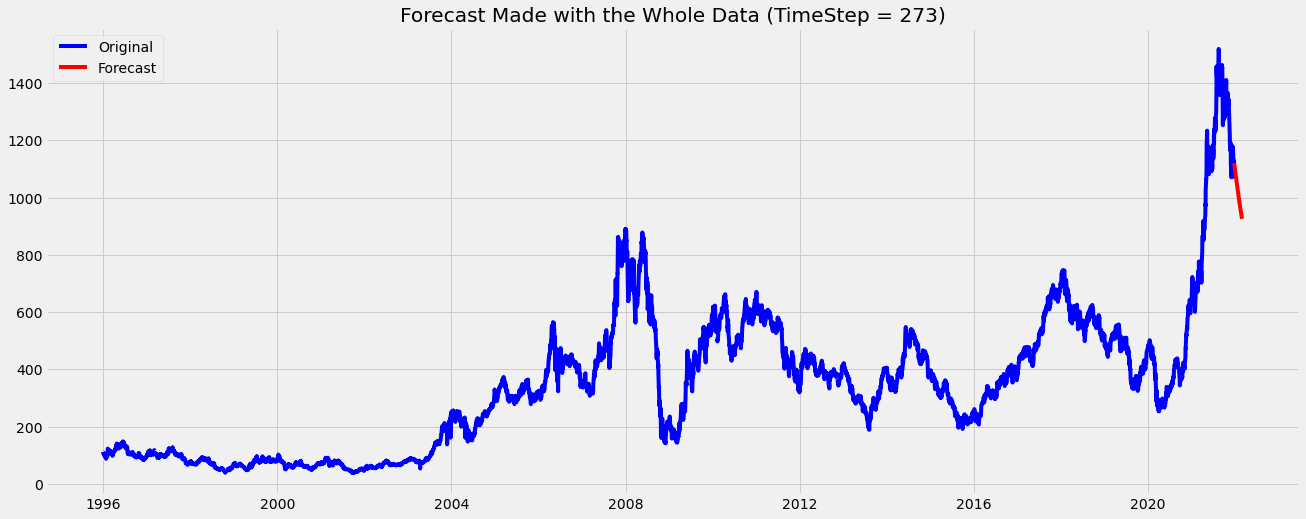

In [102]:
plt.figure(figsize=(20,8))
plt.plot(dfNew.set_index('Date'), color= 'blue', label= 'Original')
plt.plot(OpenForecasted.set_index('Date'), color= 'red', label= 'Forecast')
plt.legend(loc='best')
plt.title('Forecast Made with the Whole Data (TimeStep = 273)')
plt.show()

---
---